In [14]:
import d2lzh_pytorch as d2l
import numpy as np
import torch


def xyplot(x_vals, y_vals, name):
    d2l.set_figsize(figsize=(5, 2.5))
    d2l.plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    d2l.plt.xlabel('x')
    d2l.plt.ylabel(name + '(x)')

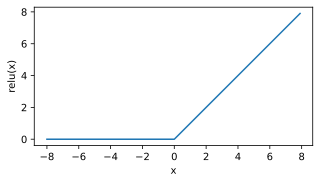

In [7]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = x.relu()
xyplot(x, y, 'relu')

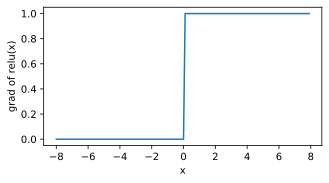

In [8]:
y.sum().backward()
xyplot(x, x.grad, 'grad of relu')

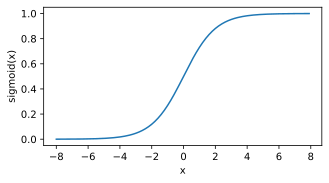

In [9]:
y = x.sigmoid()
xyplot(x, y, 'sigmoid')

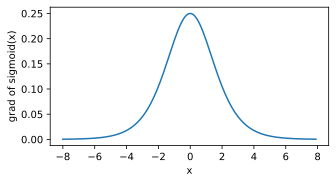

In [10]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')

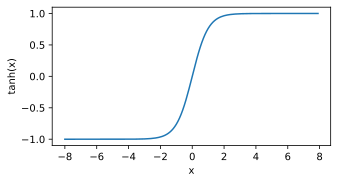

In [11]:
y = x.tanh()
xyplot(x, y, 'tanh')

In [12]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, root='./data/FashionMNIST')

In [16]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)
params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)

In [17]:
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

In [18]:
def net(X):
    X = X.view(-1, num_inputs)
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

In [19]:
loss = torch.nn.CrossEntropyLoss()

In [20]:
num_epochs, lr = 5, 100.0
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.0031, train acc 0.712, test acc 0.811
epoch 2, loss 0.0019, train acc 0.822, test acc 0.808
epoch 3, loss 0.0017, train acc 0.843, test acc 0.827
epoch 4, loss 0.0015, train acc 0.856, test acc 0.833
epoch 5, loss 0.0015, train acc 0.861, test acc 0.858


In [21]:
#  多层感知机的pytorch实现

In [22]:
from torch.nn import init
from torch import nn

net = nn.Sequential(
    d2l.FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs)
)
for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

In [23]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0032, train acc 0.696, test acc 0.787
epoch 2, loss 0.0020, train acc 0.813, test acc 0.787
epoch 3, loss 0.0017, train acc 0.840, test acc 0.810
epoch 4, loss 0.0016, train acc 0.854, test acc 0.816
epoch 5, loss 0.0015, train acc 0.862, test acc 0.787


In [121]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5

In [122]:
features = torch.randn(n_train + n_test, 1)

In [123]:
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1)

In [124]:
labels = (true_w[0] * poly_features[:, 0] +
          true_w[1] * poly_features[:, 1] +
          true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [125]:
features[: 2], poly_features[: 2], labels[: 2]

(tensor([[ 0.0620],
         [-0.2730]]),
 tensor([[ 6.2042e-02,  3.8492e-03,  2.3881e-04],
         [-2.7299e-01,  7.4524e-02, -2.0344e-02]]),
 tensor([5.0417, 4.3057]))

In [126]:
def semilogy(x_vals, y_vals, x_label, y_label,
             x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    # 对数坐标
    d2l.plt.semilogy(x_vals, y_vals)
    # 绘制测试机集上的曲线
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [127]:
num_epochs, loss = 100, torch.nn.MSELoss()


def fit_and_plot(train_features, test_features, train_labels,
                 test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    batch_size = min(10, train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features,
                                             train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size,
                                             shuffle=True)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1],
          'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data, '\nbias:', net.bias.data)

final epoch: train loss 7.986267155501992e-05 test loss 0.00010890961857512593
weight: tensor([[ 1.2042, -3.3990,  5.5990]]) 
bias: tensor([4.9966])


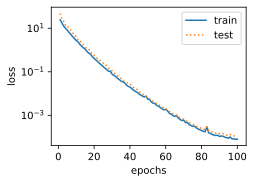

In [128]:
fit_and_plot(poly_features[:n_train, :],
             poly_features[n_train:, :],
             labels[:n_train],
             labels[n_train:])

final epoch: train loss 109.98117065429688 test loss 126.5478744506836
weight: tensor([[15.9252]]) 
bias: tensor([2.6616])


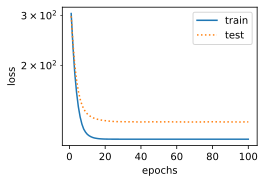

In [129]:
fit_and_plot(features[:n_train, :],
             features[n_train:, :],
             labels[:n_train],
             labels[n_train:])

final epoch: train loss 0.4636864960193634 test loss 421.0355224609375
weight: tensor([[ 0.0331,  0.6877, -0.2768]]) 
bias: tensor([4.0890])


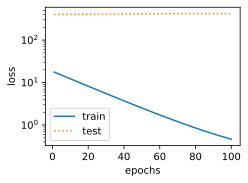

In [130]:
fit_and_plot(poly_features[:2, :],
             poly_features[n_train:, :],
             labels[:2],
             labels[n_train:])


# 高维线性回归实验

In [131]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05
features = torch.randn(n_train + n_test, num_inputs)
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features = features[:n_train, :]
test_features = features[n_train:, :]
train_labels = labels[:n_train]
test_labels = labels[n_train:]

In [132]:
# 从零实现权重衰减
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.randn(1, requires_grad=True)
    return [w, b]

In [133]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [137]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss
dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)


def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for x, y in train_iter:
            # 添加L2范数惩罚项
            l = loss(net(x, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b),
                             train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w', w.norm().item())

L2 norm of w 13.591586112976074


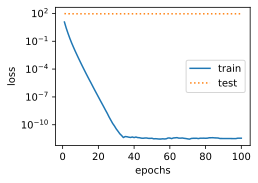

In [148]:
fit_and_plot(lambd=0)

L2 norm of w 0.04894836246967316


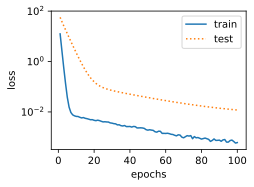

In [149]:
fit_and_plot(lambd=3)

In [150]:
def fit_and_plot_pytorch(wd):
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    # 对权重参数衰减
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd)
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            l.backward()
            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w', net.weight.data.norm().item())

L2 norm of w 13.107026100158691


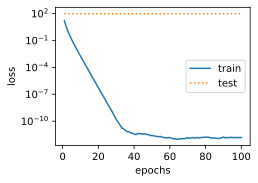

In [151]:
fit_and_plot_pytorch(0)

L2 norm of w 0.10013873130083084


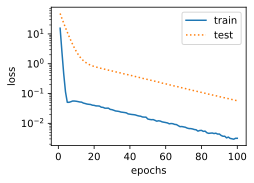

In [152]:
fit_and_plot_pytorch(3)

In [153]:
def dropout(X, drop_prob):
    X = X.float()
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    # 这种情况下把全部元素都丢弃
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape) < keep_prob).float()
    return X * mask / keep_prob

In [154]:
X = torch.arange(16).view(2, 8)
dropout(X, 0)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

In [155]:
dropout(X, 0.5)

tensor([[ 0.,  0.,  4.,  6.,  8., 10., 12.,  0.],
        [ 0.,  0.,  0., 22., 24., 26., 28., 30.]])

In [156]:
dropout(X, 1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [158]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
W1 = torch.tensor(
    np.random.normal(0, 0.01, size=(num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True
)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_outputs)),
                  dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)
params = [W1, b1, W2, b2, W3, b3]

In [160]:
drop_prob1, drop_prob2 = 0.2, 0.5


def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1) + b1).relu()
    # 只在模型训练时使用丢弃法
    if is_training:
        # 在第一层全连接后添加丢弃层
        H1 = dropout(H1, drop_prob1)
    H2 = (torch.matmul(H1, W2) + b2).relu()
    if is_training:
        # 在第二层全连接后人添加丢弃层
        H2 = dropout(H2, drop_prob2)
    return torch.matmul(H2, W3) + b3

In [163]:
num_epochs, lr, batch_size = 5, 100.0, 256
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, root='./data/FashionMNIST')
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.0016, train acc 0.853, test acc 0.832
epoch 2, loss 0.0015, train acc 0.862, test acc 0.836
epoch 3, loss 0.0015, train acc 0.865, test acc 0.839
epoch 4, loss 0.0014, train acc 0.869, test acc 0.852
epoch 5, loss 0.0014, train acc 0.872, test acc 0.837


In [164]:
net = nn.Sequential(
    d2l.FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens1),
    nn.ReLU(),
    nn.Dropout(drop_prob1),
    nn.Linear(num_hiddens1, num_hiddens2),
    nn.ReLU(),
    nn.Dropout(drop_prob2),
    nn.Linear(num_hiddens2, num_outputs)
)
for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

In [165]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
d2l.train_ch3(net, train_iter, test_iter, loss,
              num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0047, train acc 0.529, test acc 0.645
epoch 2, loss 0.0024, train acc 0.774, test acc 0.807
epoch 3, loss 0.0019, train acc 0.819, test acc 0.821
epoch 4, loss 0.0018, train acc 0.834, test acc 0.835
epoch 5, loss 0.0017, train acc 0.844, test acc 0.820
